# Sistem Rekomendasi Destinasi Wisata Berbasis Collaborative Filtering
<hr>


In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [2]:
!rm -rf data

In [3]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [4]:
! kaggle datasets download -d aprabowo/indonesia-tourism-destination

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 69.1MB/s]


In [5]:
import zipfile
import os

In [6]:
local_zip = 'indonesia-tourism-destination.zip'
target_extraction = '/content/data/'
file_check = "dataset"

try:
    if os.path.exists(os.path.join(target_extraction, file_check)):
        print("File Already Extracted")
    else:
        zip_ref = zipfile.ZipFile(local_zip, 'r')
        zip_ref.extractall(target_extraction)

except FileNotFoundError:
    print('Zip File Not Found!')

## 1. Mengimpor Library Python yang Dibutuhkan

In [7]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

In [8]:
# Upload semua dataset yang dipakai
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 3. Data Understanding

### 3.1 Menyiapkan Data

In [9]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('data/tourism_rating.csv')
place = pd.read_csv('data/tourism_with_id.csv')
user = pd.read_csv('data/user.csv')

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [10]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2


In [11]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [12]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
dtypes: float64(4), int64(2), object(5)
memory usage: 37.7+ KB


In [13]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

In [14]:
df = pd.DataFrame(place)
print("Data sebelum diurutkan:")
print(df)


Data sebelum diurutkan:
     Place_Id                                 Place_Name  \
0           1                           Monumen Nasional   
1           2                                   Kota Tua   
2           3                              Dunia Fantasi   
3           4          Taman Mini Indonesia Indah (TMII)   
4           5                   Atlantis Water Adventure   
..        ...                                        ...   
432       433                        Museum Mpu Tantular   
433       434                              Taman Bungkul   
434       435           Taman Air Mancur Menari Kenjeran   
435       436               Taman Flora Bratang Surabaya   
436       437  Gereja Perawan Maria Tak Berdosa Surabaya   

                                           Description       Category  \
0    Monumen Nasional atau yang populer disingkat d...         Budaya   
1    Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya   
2    Dunia Fantasi atau disebut juga

In [15]:

# Memfilter data berdasarkan rentang ID 1-20
# Memfilter data berdasarkan rentang ID 1-20
filter1 = df[(df['Place_Id'] >= 1) & (df['Place_Id'] <= 20)]

# Memfilter data berdasarkan rentang ID 85-105
filter2 = df[(df['Place_Id'] >= 85) & (df['Place_Id'] <= 105)]

# Memfilter data berdasarkan rentang ID 211-231
filter3 = df[(df['Place_Id'] >= 211) & (df['Place_Id'] <= 231)]

# Memfilter data berdasarkan rentang ID 335-355
filter4 = df[(df['Place_Id'] >= 335) & (df['Place_Id'] <= 355)]

# Memfilter data berdasarkan rentang ID 392-412
filter5 = df[(df['Place_Id'] >= 392) & (df['Place_Id'] <= 412)]

# Menggabungkan hasil filter
filtered_df = pd.concat([filter1, filter2, filter3, filter4, filter5])


# Mengurutkan dataset yang sudah difilter berdasarkan kolom 'ID'
place = filtered_df.sort_values(by='Place_Id')



In [16]:
# Menampilkan data setelah diurutkan
print("\nData setelah diurutkan:")
print(place)


Data setelah diurutkan:
     Place_Id                         Place_Name  \
0           1                   Monumen Nasional   
1           2                           Kota Tua   
2           3                      Dunia Fantasi   
3           4  Taman Mini Indonesia Indah (TMII)   
4           5           Atlantis Water Adventure   
..        ...                                ...   
407       408            Kebun Binatang Surabaya   
408       409                        Rumah Batik   
409       410                  Ciputra Waterpark   
410       411          Masjid Muhammad Cheng Hoo   
411       412           Masjid Nasional Al-Akbar   

                                           Description       Category  \
0    Monumen Nasional atau yang populer disingkat d...         Budaya   
1    Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya   
2    Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan   
3    Taman Mini Indonesia Indah merupakan suatu kaw...  Ta

## Data Category

#### 3.2.2. Data rating

In [17]:
df_user = pd.DataFrame(user)

# Fungsi untuk menduplikasi dan membuat variasi data
def create_variation(df_user, n):
    dfs = [df_user.copy() for _ in range(n)]
    for i, df_var in enumerate(dfs):
        df_var['User_Id'] += i * len(df_user)  # Mengubah User_Id
    return pd.concat(dfs, ignore_index=True)

# Menduplikasi dan membuat variasi pada data
df_varied = create_variation(df_user, 3)  # 3 adalah jumlah variasi

print(df_varied)

     User_Id                     Location  Age
0          1        Semarang, Jawa Tengah   20
1          2           Bekasi, Jawa Barat   21
2          3          Cirebon, Jawa Barat   23
3          4           Bekasi, Jawa Barat   21
4          5    Lampung, Sumatera Selatan   20
..       ...                          ...  ...
895      896    Lampung, Sumatera Selatan   31
896      897  Palembang, Sumatera Selatan   39
897      898            Bogor, Jawa Barat   38
898      899          Sragen, Jawa Tengah   27
899      900         Ponorogo, Jawa Timur   26

[900 rows x 3 columns]


In [18]:
df_rt = pd.DataFrame(rating)

# Fungsi untuk menduplikasi dan membuat variasi data
def create_variation(df_user, n):
    dfs = [df_rt.copy() for _ in range(n)]
    for i, df_var in enumerate(dfs):
        df_var['User_Id'] += i * len(df_rt)  # Mengubah User_Id
    return pd.concat(dfs, ignore_index=True)

# Menduplikasi dan membuat variasi pada data
df_varied = create_variation(df_rt, 3)  # 3 adalah jumlah variasi

print(df_varied)

       User_Id  Place_Id  Place_Ratings
0            1       179              3
1            1       344              2
2            1         5              5
3            1       373              3
4            1       101              4
...        ...       ...            ...
29995    20300       425              2
29996    20300        64              4
29997    20300       311              3
29998    20300       279              4
29999    20300       163              2

[30000 rows x 3 columns]


In [19]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [20]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [21]:
# Merubah data rating agar hanya berisi rating pada tempat wisata
rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


In [22]:


rating.shape

(2368, 3)

#### 3.2.3. Data user

In [23]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [24]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').sort_values('User_Id')
user.head()

,User_Id,Location,Age
83,1,"Semarang, Jawa Tengah",20
415,1,"Semarang, Jawa Tengah",20
1930,1,"Semarang, Jawa Tengah",20
825,1,"Semarang, Jawa Tengah",20
1637,1,"Semarang, Jawa Tengah",20


In [25]:
# Melihat dataset user yang pernah memberi rating pada wisata

user.shape

(2368, 3)

## 4. Eksplorasi Data

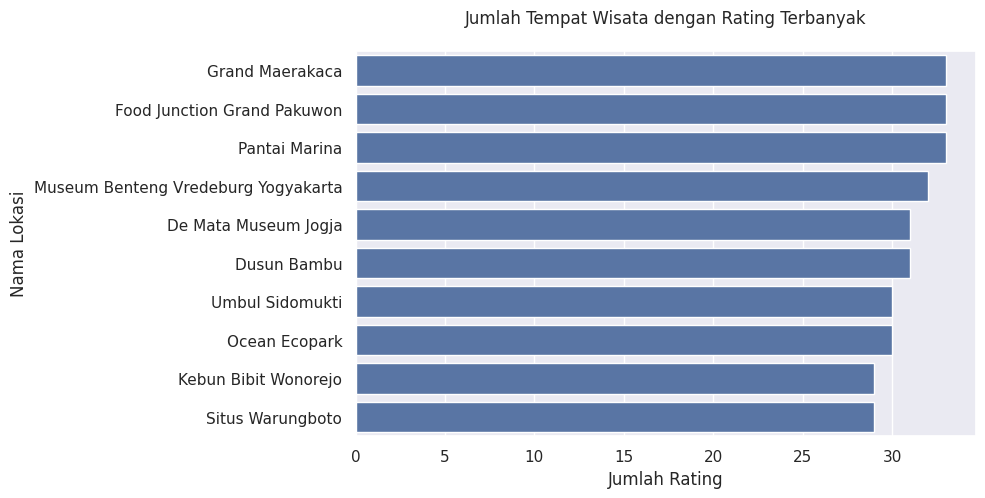

In [26]:
# Membuat dataframe berisi lokasi dengan jumlah rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10.columns = ['Place_Id', 'count']  # Rename columns for easier access
top_10 = pd.merge(top_10, place[['Place_Id', 'Place_Name']], how='left', on='Place_Id')


# Membuat visualisasi wisata dengan jumlah rating terbanyak
plt.figure(figsize=(8, 5))
sns.barplot(x='count', y='Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Rating Terbanyak', pad=20)
plt.ylabel('Nama Lokasi')
plt.xlabel('Jumlah Rating')
plt.show()

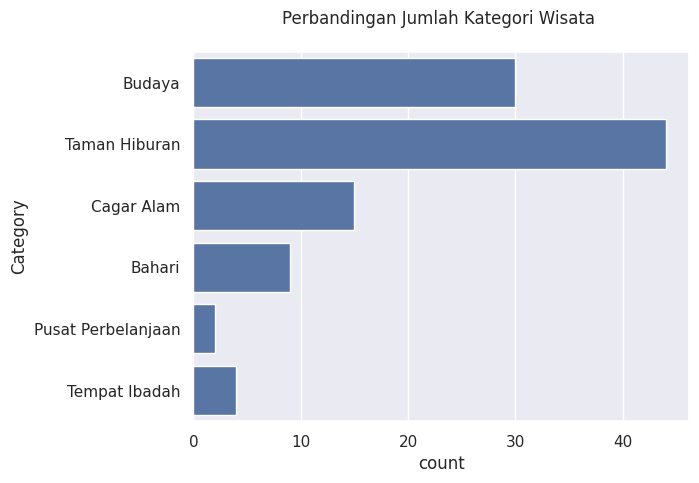

In [27]:
# Membuat visualisasi jumlah kategori wisata

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata ', pad=20)
plt.show()

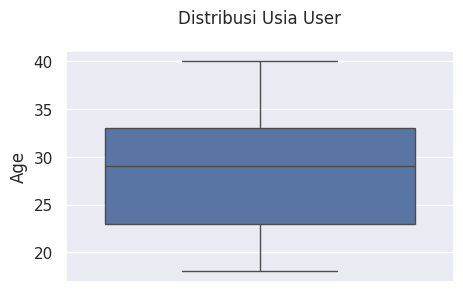

In [28]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

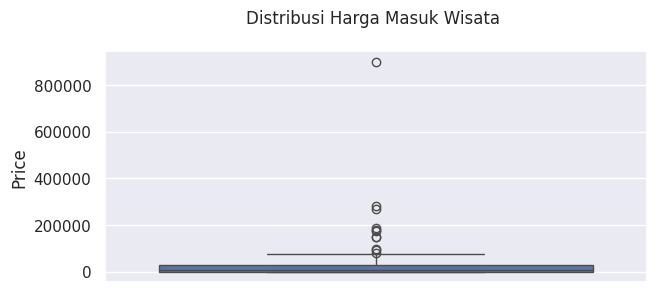

In [29]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata ', pad=20)
plt.show()

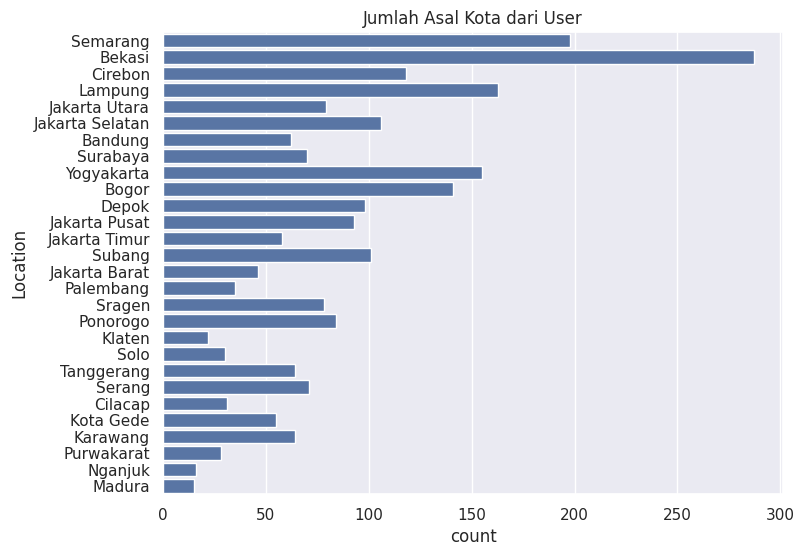

In [30]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## 5. Persiapan Data untuk Pemodelan

### 5.1. Membuat Salinan Data rating

In [31]:
# Membaca dataset untuk dilakukan encoding

df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,36,1,4
1,38,1,2
2,64,1,2
3,74,1,2
4,86,1,4


### 5.2. Melakukan Encoding

#### 5.2.1. Membuat Fungsi untuk Melakukan Encoding

In [32]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

#### 5.2.2. Encoding dan Mapping Kolom User

In [33]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

#### 5.2.3. Encoding dan Mapping Kolom Place

In [34]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)
print(df)

      User_Id  Place_Id  Place_Ratings  user  place
0          36         1              4     0      0
1          38         1              2     1      0
2          64         1              2     2      0
3          74         1              2     3      0
4          86         1              4     4      0
...       ...       ...            ...   ...    ...
2363      191       412              3   292    103
2364      221       412              4   257    103
2365      226       412              5    87    103
2366      227       412              4    14    103
2367      262       412              1   134    103

[2368 rows x 5 columns]


### 5.3. Melihat Gambaran Data untuk Pemodelan

In [35]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 300, Number of Place: 104, Min Rating: 1.0, Max Rating: 5.0


In [36]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings,user,place
1094,289,217,2.0,242,47
188,61,9,3.0,141,8


## 6. Pemodelan Machine Learning

### 6.1. Membagi data train dan test

In [37]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### 6.2. Menyiapkan Model

#### Deklarasi Fungsi

In [38]:
def dict_encoder(col, data):
    unique_val = data[col].unique().tolist()
    val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
    val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
    return val_to_val_encoded, val_encoded_to_val

def encode_data(df):
    user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id', df)
    df['user'] = df['User_Id'].map(user_to_user_encoded)

    place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id', df)
    df['place'] = df['Place_Id'].map(place_to_place_encoded)

    return df, user_to_user_encoded, place_to_place_encoded


#### Membaca, Mengolah, dan Mempersiapkan Data:

In [39]:

# Membaca data dan melakukan encoding
df_encoded, user_to_user_encoded, place_to_place_encoded = encode_data(rating)

# Mendapatkan jumlah user dan place
num_users, num_places = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah rating menjadi nilai float
df_encoded['Place_Ratings'] = df_encoded['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df_encoded['Place_Ratings']), max(df_encoded['Place_Ratings'])

#### Pembagian Data dan Persiapan untuk Pelatihan:

#### Inisialisasi dan Pelatihan Model:

In [59]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import GaussianNoise, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


def create_ncf_model(num_users, num_places, embedding_size=50):
    user_input = Input(shape=(1,), name='user_input')
    place_input = Input(shape=(1,), name='place_input')

    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    user_embedding = GaussianNoise(0.1)(user_embedding)

    place_embedding = Embedding(input_dim=num_places, output_dim=embedding_size, name='place_embedding')(place_input)
    place_embedding = GaussianNoise(0.1)(place_embedding)

    user_flatten = Flatten()(user_embedding)
    place_flatten = Flatten()(place_embedding)

    concat = Concatenate()([user_flatten, place_flatten])

    dense = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3))(concat)
    batch_norm = BatchNormalization()(dense)
    dropout = Dropout(0.3)(batch_norm)  # Reduced dropout rate

    dense_2 = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3))(dropout)
    batch_norm_2 = BatchNormalization()(dense_2)
    dropout_2 = Dropout(0.3)(batch_norm_2)  # Reduced dropout rate

    dense_3 = Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3))(dropout_2)
    batch_norm_3 = BatchNormalization()(dense_3)
    dropout_3 = Dropout(0.3)(batch_norm_3)  # Reduced dropout rate

    output = Dense(1, activation='sigmoid')(dropout_3)

    model = Model(inputs=[user_input, place_input], outputs=output)
    model.compile(loss='mse', optimizer=Adam(learning_rate=1e-4), metrics=['mse'])  # Reduced learning rate

    return model

model = create_ncf_model(num_users, num_places, embedding_size=50)
model.summary()

# EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    x=[x_train[:, 0], x_train[:, 1]],
    y=y_train,
    batch_size=128,
    epochs=50,
    validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
    callbacks=[early_stopping, reduce_lr]  # Added callbacks
)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 place_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 50)                15000     ['user_input[0][0]']          
                                                                                                  
 place_embedding (Embedding  (None, 1, 50)                5200      ['place_input[0][0]']         
 )                                                                                          

#### Visualisasi Hasil Pelatihan

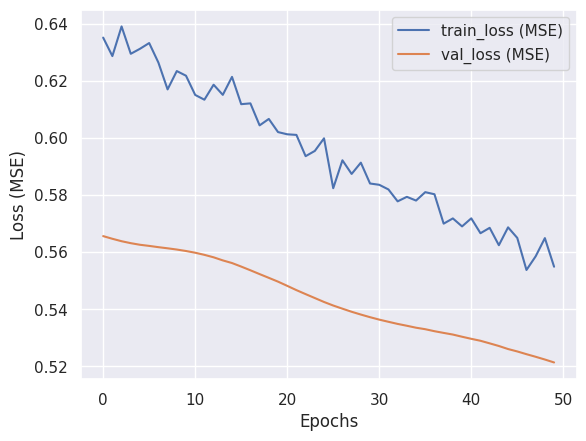

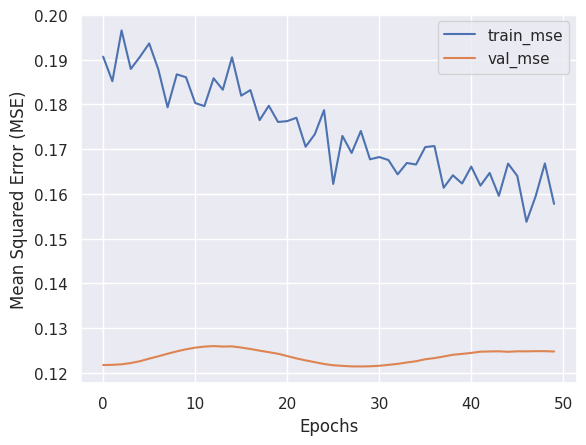

In [60]:
import matplotlib.pyplot as plt

# Plot loss (MSE) selama pelatihan dan validasi
plt.plot(history.history['loss'], label='train_loss (MSE)')
plt.plot(history.history['val_loss'], label='val_loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Plot MSE selama pelatihan dan validasi
plt.plot(history.history['mse'], label='train_mse')
plt.plot(history.history['val_mse'], label='val_mse')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.show()


## hasil rekomendasi untuk user

In [42]:
# Buat DataFrame baru yang berisi semua pasangan pengguna-tempat yang mungkin
all_users = np.array(list(user_to_user_encoded.values()))
all_places = np.array(list(place_to_place_encoded.values()))
all_user_place = np.array(np.meshgrid(all_users, all_places)).T.reshape(-1, 2)
df_all_user_place = pd.DataFrame(all_user_place, columns=['user', 'place'])

# Gunakan model yang sudah dilatih untuk membuat prediksi rating
predictions = model.predict([df_all_user_place['user'], df_all_user_place['place']])

# Tambahkan prediksi rating ke DataFrame
df_all_user_place['predicted_rating'] = predictions.flatten()

# Urutkan hasil prediksi berdasarkan rating tertinggi
df_recommendations = df_all_user_place.sort_values(by='predicted_rating', ascending=False)

# Tampilkan hasil rekomendasi dalam bentuk DataFrame
print(df_recommendations.head(10))


975/975 [==============================] - 3s 2ms/step
       user  place  predicted_rating
187       1     83          0.739470
130       1     26          0.735171
164       1     60          0.735089
191       1     87          0.732488
117       1     13          0.731244
190       1     86          0.730373
196       1     92          0.730254
121       1     17          0.727830
20155   193     83          0.726533
20132   193     60          0.722324


In [43]:
# Group the recommendations by place and sort them by predicted rating in descending order
grouped_recommendations = df_recommendations.groupby('place').apply(lambda x: x.sort_values(by='predicted_rating', ascending=False))

# Print the top 10 recommendations with the highest rating, considering only one recommendation per place
print("Top 10 Cultural Recommendations:")
seen_places = set()
recommendations_count = 0
for index, row in grouped_recommendations.iterrows():
    place_id = place_encoded_to_place[row['place']]
    if place_id not in seen_places:
        place_details = place[place['Place_Id'] == place_id]
        category = place_details['Category'].iloc[0]

        # Check if the place belongs to the 'Culture' category
        if category == 'Taman Hiburan':
            place_name = place_details['Place_Name'].iloc[0]
            price = place_details['Price'].iloc[0]
            rating = place_details['Rating'].iloc[0]

            print(f"Place ID: {place_id}")
            print(f"Place Name: {place_name}")
            print(f"Category: {category}")
            print(f"Price: {price}")
            print(f"Rating: {rating}")
            print("\n")

            seen_places.add(place_id)
            recommendations_count += 1

            if recommendations_count >= 10:
                break


Top 10 Cultural Recommendations:
Place ID: 3
Place Name: Dunia Fantasi
Category: Taman Hiburan
Price: 270000
Rating: 4.6


Place ID: 4
Place Name: Taman Mini Indonesia Indah (TMII)
Category: Taman Hiburan
Price: 10000
Rating: 4.5


Place ID: 5
Place Name: Atlantis Water Adventure
Category: Taman Hiburan
Price: 94000
Rating: 4.5


Place ID: 6
Place Name: Taman Impian Jaya Ancol
Category: Taman Hiburan
Price: 25000
Rating: 4.5


Place ID: 8
Place Name: Ocean Ecopark
Category: Taman Hiburan
Price: 180000
Rating: 4.0


Place ID: 19
Place Name: Kidzania
Category: Taman Hiburan
Price: 185000
Rating: 4.6


Place ID: 85
Place Name: Taman Pintar Yogyakarta
Category: Taman Hiburan
Price: 6000
Rating: 4.5


Place ID: 87
Place Name: Sindu Kusuma Edupark (SKE)
Category: Taman Hiburan
Price: 20000
Rating: 4.2


Place ID: 90
Place Name: Kampung Wisata Taman Sari
Category: Taman Hiburan
Price: 5000
Rating: 4.6


Place ID: 91
Place Name: Situs Warungboto
Category: Taman Hiburan
Price: 0
Rating: 4.4




In [44]:
# Group the recommendations by place and sort them by predicted rating in descending order
grouped_recommendations = df_recommendations.groupby('place').apply(lambda x: x.sort_values(by='predicted_rating', ascending=False))

# Print the top 10 recommendations with the highest rating, considering only one recommendation per place
print("Top 10 Cultural Recommendations:")
seen_places = set()
recommendations_count = 0
for index, row in grouped_recommendations.iterrows():
    place_id = place_encoded_to_place[row['place']]
    if place_id not in seen_places:
        place_details = place[place['Place_Id'] == place_id]
        category = place_details['City'].iloc[0]

        # Check if the place belongs to the 'Culture' category
        if category == 'Jakarta':
            place_name = place_details['Place_Name'].iloc[0]
            price = place_details['Price'].iloc[0]
            rating = place_details['Rating'].iloc[0]

            print(f"Place ID: {place_id}")
            print(f"Place Name: {place_name}")
            print(f"Category: {category}")
            print(f"Price: {price}")
            print(f"Rating: {rating}")
            print("\n")

            seen_places.add(place_id)
            recommendations_count += 1

            if recommendations_count >= 10:
                break


Top 10 Cultural Recommendations:
Place ID: 1
Place Name: Monumen Nasional
Category: Jakarta
Price: 20000
Rating: 4.6


Place ID: 2
Place Name: Kota Tua
Category: Jakarta
Price: 0
Rating: 4.6


Place ID: 3
Place Name: Dunia Fantasi
Category: Jakarta
Price: 270000
Rating: 4.6


Place ID: 4
Place Name: Taman Mini Indonesia Indah (TMII)
Category: Jakarta
Price: 10000
Rating: 4.5


Place ID: 5
Place Name: Atlantis Water Adventure
Category: Jakarta
Price: 94000
Rating: 4.5


Place ID: 6
Place Name: Taman Impian Jaya Ancol
Category: Jakarta
Price: 25000
Rating: 4.5


Place ID: 7
Place Name: Kebun Binatang Ragunan
Category: Jakarta
Price: 4000
Rating: 4.5


Place ID: 8
Place Name: Ocean Ecopark
Category: Jakarta
Price: 180000
Rating: 4.0


Place ID: 9
Place Name: Pelabuhan Marina
Category: Jakarta
Price: 175000
Rating: 4.4


Place ID: 10
Place Name: Pulau Tidung
Category: Jakarta
Price: 150000
Rating: 4.5






# save model





In [45]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
import os

model.save('best_model.h5')
# Memuat model dengan eksplisit menyertakan MeanSquaredError sebagai custom object
model = load_model('best_model.h5', custom_objects={'mse': MeanSquaredError()})

In [46]:
import joblib

joblib.dump(model, 'model.pkl')

['model.pkl']

# Menyimpan DataFrame ke file CSV

In [47]:
place.to_csv('data/place_data.csv', index=False)

# API untuk Prediksi

In [48]:
import joblib

joblib.dump(user_to_user_encoded, 'user_to_user_encoded.pkl')
joblib.dump(place_to_place_encoded, 'place_to_place_encoded.pkl')

['place_to_place_encoded.pkl']

In [49]:
from flask import Flask, request, jsonify
import tensorflow as tf
import joblib

app = Flask(__name__)

# Muat model terlatih
model = tf.keras.models.load_model('best_model.h5')

# Muat dictionary encoding
user_to_user_encoded = joblib.load('user_to_user_encoded.pkl')
place_to_place_encoded = joblib.load('place_to_place_encoded.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    user_id = data.get('user_id')
    place_id = data.get('place_id')

    user_encoded = user_to_user_encoded.get(user_id, None)
    place_encoded = place_to_place_encoded.get(place_id, None)

    if user_encoded is None or place_encoded is None:
        return jsonify({'error': 'User or Place not found'}), 400

    prediction = model.predict([[user_encoded], [place_encoded]])
    rating = prediction[0][0]

    return jsonify({'rating': rating})

if __name__ == '__main__':
    app.run(host='127.0.0.1', port=8092)


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8092
INFO:werkzeug:Press CTRL+C to quit
